Predicting Survival in the Titanic Data Set
We will be using a decision tree to make predictions about the Titanic data set from
Kaggle. This data set provides information on the Titanic passengers and can be used to
predict whether a passenger survived or not.

You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch (Parents/children aboard),
and Fare to predict whether a passenger survived.

In [120]:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import tree, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
import pydotplus
from IPython.display import Image, display

## Data Preprocessing

In [95]:
url="https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
titanic = pd.read_csv(url)
titanic.columns =['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration

In [65]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [66]:
titanic.shape

(891, 12)

In [67]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [68]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


## Data cleaning

In [69]:
titanic.isna().values.any()

True

In [70]:
titanic.isnull().values.any()

True

In [71]:
titanic.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 Therefore 'Age', 'cabin' and 'embarked' are having missing values of 177, 687 and 2. 

## Data Visualization

### PClass

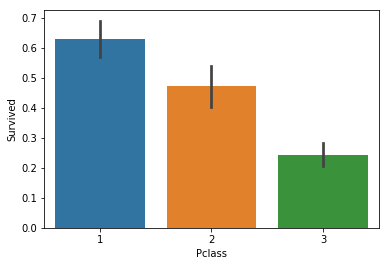

In [72]:
sb.barplot(x='Pclass', y='Survived', data=titanic)

Pclass is contributing to a persons chance of survival, especially if this person is in class 1.

c:\users\dnaga\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


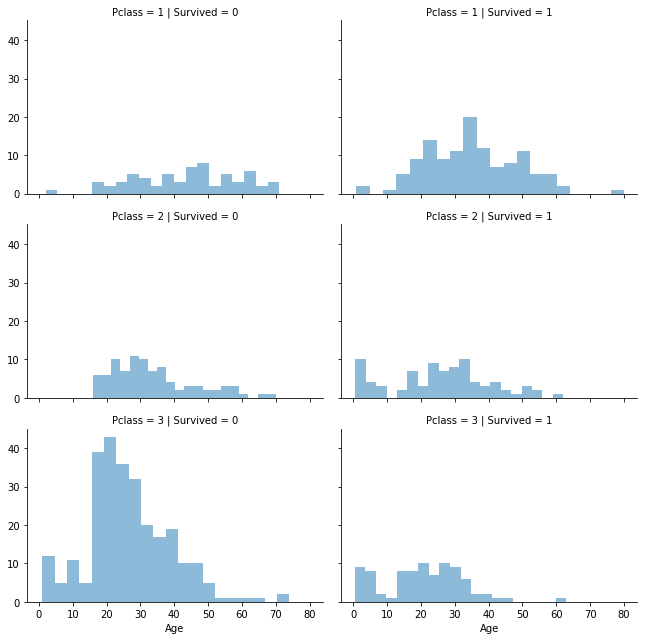

In [73]:
grid = sb.FacetGrid(titanic, col='Survived', row='Pclass', size=3, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

There is a high probability that a person in pclass 3 will not survive.

### SibSp and Parch

In [74]:
titanic_temp = titanic
titanic_temp['relatives'] = titanic_temp['SibSp'] + titanic_temp['Parch']
titanic_temp.loc[titanic_temp['relatives'] > 0, 'not_alone'] = 0
titanic_temp.loc[titanic_temp['relatives'] == 0, 'not_alone'] = 1
titanic_temp['not_alone'] = titanic_temp['not_alone'].astype(int)
titanic_temp['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

c:\users\dnaga\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


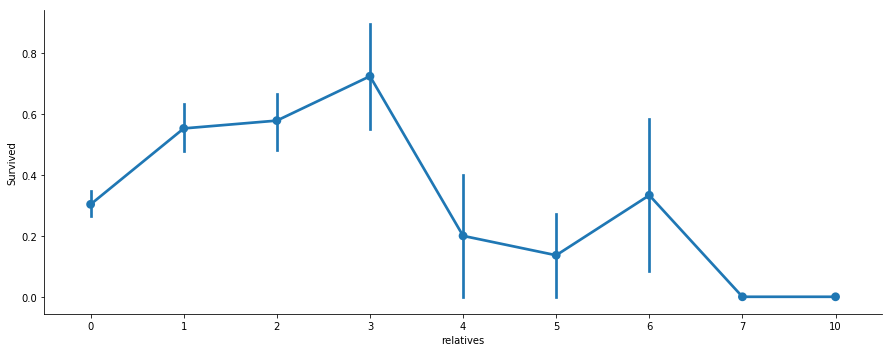

In [75]:
axes = sb.factorplot('relatives','Survived', data=titanic_temp, aspect = 2.5, )

### Age and Sex

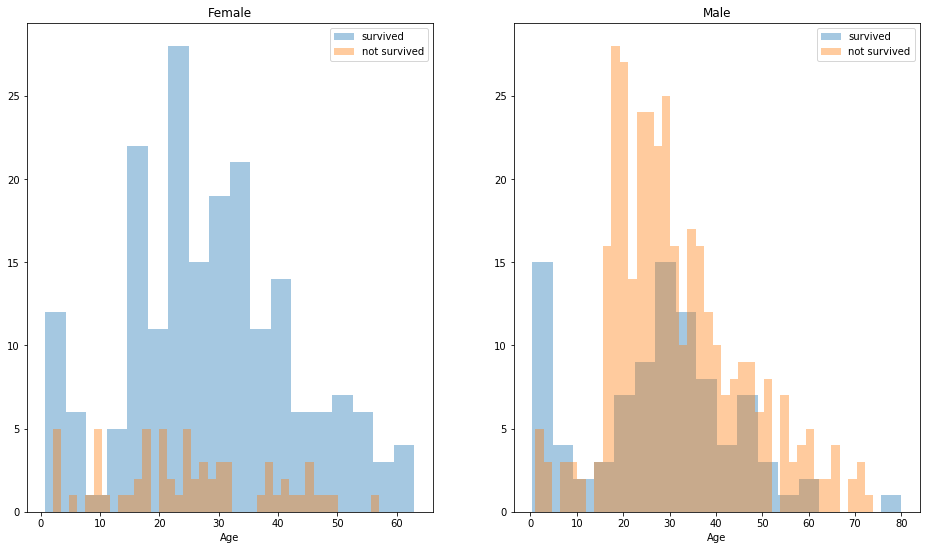

In [76]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 9))
women = titanic[titanic['Sex']=='female']
men = titanic[titanic['Sex']=='male']
ax = sb.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sb.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sb.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sb.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

We can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

### Embarked, Pclass and Sex

c:\users\dnaga\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


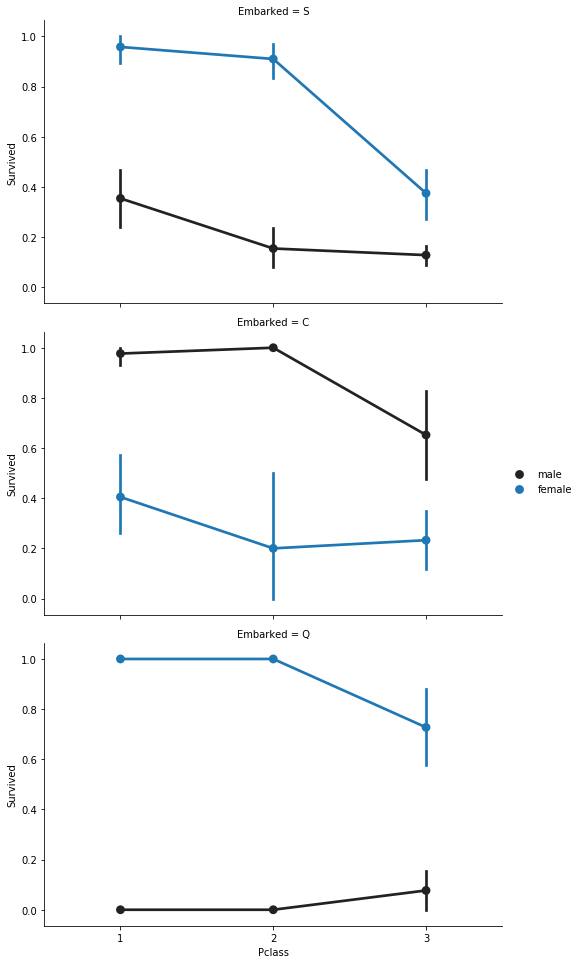

In [77]:
FacetGrid = sb.FacetGrid(titanic, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sb.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender.

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

## Data Preprocessing for Missing data in Age, Cabin and Embarked

### Age

In [78]:
titanic2 = titanic

titanic2['Age'].isna().values.any()

True

In [79]:
mean = titanic2["Age"].mean()
std = titanic2["Age"].std()
is_null = titanic2["Age"].isnull().sum()

#Computing random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)

#Filling NaN values in Age column with random values generated
age_slice = titanic2["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
titanic2["Age"] = age_slice
titanic2["Age"] = titanic2["Age"].astype(int)

In [80]:
titanic2['Age'].isna().values.any()

False

### Cabin

In [81]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

titanic2['Cabin'] = titanic2['Cabin'].fillna("U0")
titanic2['Deck'] = titanic2['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
titanic2['Deck'] = titanic2['Deck'].map(deck)
titanic2['Deck'] = titanic2['Deck'].fillna(0)
titanic2['Deck'] = titanic2['Deck'].astype(int)

#I will now drop the cabin feature
titanic2 = titanic2.drop(['Cabin'], axis=1)

In [82]:
titanic2['Deck'].isna().sum()

0

In [83]:
titanic2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,1,0,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,0,1,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,1,0,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,0,1,8


### Embarked

In [84]:
titanic2['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [85]:
top_value = 'S'
titanic2['Embarked'] = titanic2['Embarked'].fillna(top_value)

In [86]:
titanic2['Embarked'].isna().sum()

0

There should not be any missing values since we handled all the columns contained missing values

In [87]:
titanic2.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
relatives      0
not_alone      0
Deck           0
dtype: int64

In [88]:
titanic2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
relatives      891 non-null int64
not_alone      891 non-null int32
Deck           891 non-null int32
dtypes: float64(1), int32(3), int64(6), object(4)
memory usage: 73.1+ KB


Now ready to move to data preparation as we dont have any missing values in our dataset. 

## Data Preparation

In [89]:
#Convert Sex column into numeric
genders = {"male": 1, "female": 0}
titanic2['Sex'] = titanic2['Sex'].map(genders)

#or we can do like this also
#temp = pd.get_dummies(titanic2['Sex'], prefix='Sex', prefix_sep='_')
#titanic2 = pd.concat([titanic2, temp], axis=1)

In [90]:
titanic2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,S,1,0,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,S,0,1,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53.1000,S,1,0,3
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8.0500,S,0,1,8


Converting Fare from float into integer

In [91]:
titanic2['Fare'].isna().sum()

0

In [92]:
titanic2['Fare'] = titanic2['Fare'].astype(int)

In [93]:
titanic2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,relatives,not_alone,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7,S,1,0,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71,C,1,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7,S,0,1,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35,1,0,113803,53,S,1,0,3
4,5,0,3,"Allen, Mr. William Henry",1,35,0,0,373450,8,S,0,1,8


Make sure everything is good by comparing titanic and titanic2

In [96]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [97]:
titanic2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            891 non-null int32
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null int32
Embarked       891 non-null object
relatives      891 non-null int64
not_alone      891 non-null int32
Deck           891 non-null int32
dtypes: int32(4), int64(7), object(3)
memory usage: 73.1+ KB


## Split into Train data and test data

In [99]:
#target
y = titanic2['Survived']

#attributes
X = titanic2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]


In [100]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(623, 6)
(268, 6)
(623,)
(268,)


## Creating and Fit the model to train data

In [101]:
dtree =  tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

## Predict passengers survived using test data

In [102]:
y_predict = dtree.predict(X_test)

In [103]:
y_predict

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0], dtype=int64)

In [104]:
y_predict.shape

(268,)

## Decision tree Visualization using GraphViz

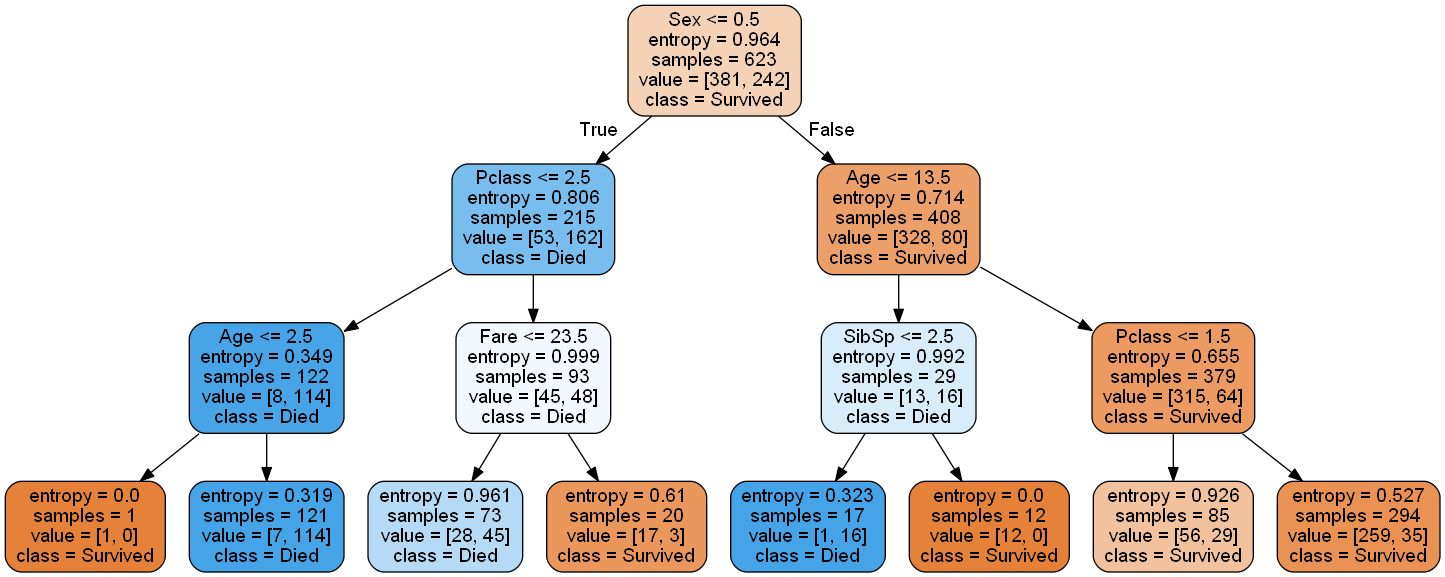

In [105]:
import os
os.environ['Path']+=os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
dot_data = tree.export_graphviz(dtree, out_file=None, filled=True, rounded=True,
                                feature_names=['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'],  
                                class_names=['Survived','Died'])
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

## Model Evaluation

In [107]:
count_misclassified = (y_test != y_predict).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_predict)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 48
Accuracy: 0.82


In [126]:
cv = KFold(n_splits=10,
           random_state=12) 

fold_accuracy = []

for train_fold, valid_fold in cv.split(X, y):
    train = X.loc[train_fold] #Extract train data with cv indices
    valid = X.loc[valid_fold] #Extract valid data with cv indices
    
    train_y = y.loc[train_fold]
    valid_y = y.loc[valid_fold]
    
    model = dtree.fit(X = train, y = train_y)
    valid_acc = model.score(X = valid, y = valid_y)
    fold_accuracy.append(valid_acc)    

print("Accuracy per fold: ", fold_accuracy, "\n")
print("Average accuracy: ", sum(fold_accuracy)/len(fold_accuracy))

Accuracy per fold:  [0.8222222222222222, 0.8539325842696629, 0.7865168539325843, 0.8426966292134831, 0.7865168539325843, 0.8089887640449438, 0.7752808988764045, 0.7752808988764045, 0.8876404494382022, 0.8089887640449438] 

Average accuracy:  0.8148064918851438


## Cross Validation

In [132]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator= dtree, #Model to test
                X = X,  
                y = y,                #Target variable
                scoring = "accuracy", #Scoring metric    
                cv=10)                #Cross validation folds

print("Accuracy per fold: ")
print(scores)
print("Average accuracy: ", scores.mean()*100)

Accuracy per fold: 
[0.82222222 0.82222222 0.78651685 0.84269663 0.82022472 0.78651685
 0.79775281 0.78651685 0.85393258 0.80681818]
Average accuracy:  81.25419929633415


In [129]:
#Checking classification text report for y_test and prediction from metrics
report = sklearn.metrics.classification_report(y_test, y_predict)

In [131]:
print(report)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       168
           1       0.77      0.74      0.76       100

   micro avg       0.82      0.82      0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

